<a href="https://colab.research.google.com/github/jcmachicaocuf/CUF__NLP_LLM/blob/main/cuf_nlp_wk01_ejemplo_proceso_tradicional_costos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Herramientas NLP para analisis de reportes de corrupción

In [ ]:
!python -m spacy download es_core_news_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/es_core_news_sm-3.8.0/es_core_news_sm-3.8.0-py3-none-any.whl (12.9 MB)
[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


In [ ]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 330.3 kB/s eta 0:00:39
     --------------------------------------- 0.1/12.8 MB 656.4 kB/s eta 0:00:20
      --------------------------------------- 0.2/12.8 MB 1.7 MB/s eta 0:00:08
     - -------------------------------------- 0.6/12.8 MB 3.3 MB/s eta 0:00:04
     --- ------------------------------------ 1.1/12.8 MB 5.0 MB/s eta 0:00:03
     ----- ---------------------------------- 1.6/12.8 MB 6.6 MB/s eta 0:00:02
     ------ --------------------------------- 2.2/12.8 MB 7.3 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 7.9 MB/s eta 0:00:02
     ---------- ----------------------------- 3.3/12.8 MB 8.4 MB/s eta 0:00:02
     ----------- ---------------------------- 3.8/12.8 MB 8.7 MB/s eta 0:00:02
     ------------- -------------------------- 4.4/12.8 MB 9.0 MB/s eta 0:00:01
     --------------- ------------------------ 4.9/12.8 MB

In [ ]:
import spacy
import es_core_news_sm, en_core_web_sm
import pandas as pd
import numpy as np
from collections import defaultdict
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_similarity
import time
import psutil
import warnings
from typing import List, Dict, Tuple, Set
import re
from datetime import datetime
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import seaborn as sns

In [ ]:
# Cargar modelo de spaCy
nlp = es_core_news_sm.load()
nlp_en = en_core_web_sm.load()

In [ ]:
# Métricas de rendimiento
performance_metrics = {
    'processing_time': [],
    'memory_usage': [],
    'processed_chars': 0
}

start_time = time.time()

# Inicializar vectorizador TF-IDF
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    stop_words=nlp.Defaults.stop_words
)

# Inicializar modelo Word2Vec
word2vec = None

In [ ]:
# Inicializar vectorizador TF-IDF con stop words en español
tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 3),
    stop_words=None  # Inicialmente sin stop words
)

# Manejaremos las stop words manualmente en el preprocesamiento
stop_words = set(nlp.Defaults.stop_words)

# Inicializar modelo Word2Vec
word2vec = None

In [ ]:
def _track_performance(text_length: int):
    """Registra métricas de rendimiento."""
    current_time = time.time()
    memory_used = psutil.Process().memory_info().rss / 1024 / 1024  # MB

    performance_metrics['processing_time'].append(current_time - start_time)
    performance_metrics['memory_usage'].append(memory_used)
    performance_metrics['processed_chars'] += text_length

    return performance_metrics

In [ ]:
ejemplo_texto = [
    "Hay un proveedor que trajo regalos para los evaluadores del proceso. Creo que esto representa un riesgo elevado porque nadie está haciendo seguimiento de las visitas de este proveedor, y hay contratos importantes que podrían tener influencia. Estos contratos son del nivel de US$250 mil y US$340 mil, y esto podría tener consecuencias porque además involucran a varias Municipalidades de Trujillo y Ferreñafe. Podría ser sospechoso que los proveedores hagan esto muy frecuentemente.",
    "Tengo temor de que las organizaciones empiecen a dejar entrar empleados que no tengan suficiente integridad, porque ya no vienen formados con criterios éticos, no hay formación universitaria completa en estos temas, especialmente en la Municipalidad de Lima que presenta una acción sospechosa. Creo que esto representa un riesgo elevado porque nadie está haciendo seguimiento de las visitas de este proveedor, y hay contratos importantes que podrían tener influencia. Esto suele generar que la mayoría de profesionales no estén alertas ante la presencia de las mafias.",
    "Los contratos no tienen cláusulas de protección contra la manipulación de proveedores con acciones sospechosas, parece que no hay muy buena garantía de que las cosas se puedan corregir a tiempo. Las aprobaciones parecen estar demorando más de lo debido y esto ya representa una situación bastante sospechosa para lo que podría estar ocurriendo. No hay gente responsable que se atreva a denunciar estos riesgos, sobre todo cuando los proveedores vienen de Ecuador. Podría ser sospechoso que los proveedores hagan esto muy frecuentemente."
]
largo_texto = len(ejemplo_texto)

In [ ]:
_track_performance(largo_texto)

{'processing_time': [4.954621076583862,
  14.801689147949219,
  14.812690496444702,
  14.822633504867554,
  159.4389910697937,
  159.44996213912964,
  159.45993494987488,
  216.12560963630676,
  228.78567552566528,
  228.79664659500122,
  228.8076171875,
  370.2679913043976],
 'memory_usage': [443.77734375,
  444.0703125,
  444.0703125,
  444.07421875,
  703.73046875,
  703.73046875,
  704.07421875,
  716.18359375,
  716.84765625,
  716.8515625,
  716.8515625,
  726.44140625],
 'processed_chars': 4470}

In [ ]:
def _extract_entities(doc) -> Dict[str, Set[str]]:
    """Extrae entidades relevantes del documento."""
    entities = {
        'personas': set(),
        'organizaciones': set(),
        'lugares': set(),
        'fechas': set(),
        'cantidades': set()
    }

    for ent in doc.ents:
        if ent.label_ == 'PER':
            entities['personas'].add(ent.text)
        elif ent.label_ == 'ORG':
            entities['organizaciones'].add(ent.text)
        elif ent.label_ == 'LOC':
            entities['lugares'].add(ent.text)
        elif ent.label_ == 'DATE':
            entities['fechas'].add(ent.text)
        elif ent.label_ == 'MONEY':
            entities['cantidades'].add(ent.text)

    return entities

In [ ]:
for texto in ejemplo_texto:
    doc = nlp(texto)
    doc_en = nlp_en(texto)
    print(_extract_entities(doc))
    print(_extract_entities(doc_en))

{'personas': {'Ferreñafe', 'Podría'}, 'organizaciones': {'Creo'}, 'lugares': {'Municipalidades de Trujillo'}, 'fechas': set(), 'cantidades': set()}
{'personas': set(), 'organizaciones': {'Municipalidades de Trujillo y Ferreñafe', 'haciendo seguimiento de las visitas de este proveedor', 'un', 'Hay un'}, 'lugares': set(), 'fechas': set(), 'cantidades': {'250', '340'}}
{'personas': set(), 'organizaciones': set(), 'lugares': {'Municipalidad de Lima'}, 'fechas': set(), 'cantidades': set()}
{'personas': set(), 'organizaciones': {'haciendo seguimiento de las visitas de este proveedor', 'Esto', 'Tengo temor de que', 'un'}, 'lugares': set(), 'fechas': set(), 'cantidades': set()}
{'personas': {'Podría'}, 'organizaciones': set(), 'lugares': {'Ecuador'}, 'fechas': set(), 'cantidades': set()}
{'personas': set(), 'organizaciones': {'ya representa una situación bastante sospechosa'}, 'lugares': set(), 'fechas': set(), 'cantidades': set()}


In [ ]:
def _build_relationship_graph(entities: Dict[str, Set[str]]) -> nx.Graph:
    """Construye un grafo de relaciones entre entidades."""
    G = nx.Graph()

    # Agregar nodos
    for entity_type, entity_set in entities.items():
        for entity in entity_set:
            G.add_node(entity, type=entity_type)

    # Conectar entidades que aparecen en el mismo contexto
    for entity_type1, entities1 in entities.items():
        for entity_type2, entities2 in entities.items():
            if entity_type1 < entity_type2:  # Evitar duplicados
                for e1 in entities1:
                    for e2 in entities2:
                        G.add_edge(e1, e2, weight=1)

    return G

In [ ]:
incident_patterns = [
    # Patrones de corrupción
    [{'LOWER': {'IN': ['soborno', 'coima', 'riesgo', 'mordida']}},
     {'POS': 'NOUN', 'OP': '?'}],
    [{'LOWER': 'ofrecer'},
     {'LOWER': 'dinero'}],
    # Patrones de uso indebido
    [{'LOWER': {'IN': ['robo', 'hurto', 'sustracción']}},
     {'POS': 'ADP', 'OP': '?'},
     {'POS': 'NOUN'}],
    # Patrones de irregularidades
    [{'LOWER': {'IN': ['irregular', 'sospechoso', 'sospechosa', 'dudoso', 'dudosa']}},
     {'POS': 'NOUN'}]
]

In [ ]:
# Configurar el matcher de spaCy
matcher = spacy.matcher.Matcher(nlp.vocab)

In [ ]:
for idx, pattern in enumerate(incident_patterns):
    print(idx, pattern)
    matcher.add(f"incident_pattern_{idx}", [pattern])

0 [{'LOWER': {'IN': ['soborno', 'coima', 'riesgo', 'mordida']}}, {'POS': 'NOUN', 'OP': '?'}]
1 [{'LOWER': 'ofrecer'}, {'LOWER': 'dinero'}]
2 [{'LOWER': {'IN': ['robo', 'hurto', 'sustracción']}}, {'POS': 'ADP', 'OP': '?'}, {'POS': 'NOUN'}]
3 [{'LOWER': {'IN': ['irregular', 'sospechoso', 'sospechosa', 'dudoso', 'dudosa']}}, {'POS': 'NOUN'}]


In [ ]:
matches = matcher(doc)
matches

[]

In [ ]:
def _detect_incident_patterns(doc, matches) -> List[Dict]:
    """Detecta patrones de incidentes en el texto."""
    incidents = []

    for match_id, start, end in matches:
        print(start, end)
        span = doc[start:end]
        sentence = span.sent
        main_verbs = [token.text for token in sentence
                     if token.pos_ == "VERB" and token.dep_ in ["ROOT", "ccomp"]]

        incidents.append({
            'pattern': span.text,
            'sentence': sentence.text,
            'verbs': main_verbs,
            'start_char': sentence.start_char,
            'end_char': sentence.end_char
        })

    return incidents

In [ ]:
def train_word2vec(texts: List[str]):
    """Entrena un modelo Word2Vec con los textos proporcionados."""
    sentences = []
    for text in texts:
        doc = nlp(text)
        sentences.append([token.text.lower() for token in doc
                        if not token.is_stop and not token.is_punct])

    word2vec = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

In [ ]:
def find_similar_incidents(texts: List[str], min_similarity: float = 0.5) -> List[List[int]]:
    """
    Encuentra grupos de incidentes similares usando DBSCAN.
    """
    # Preprocesar textos eliminando stop words
    processed_texts = []
    for text in texts:
        doc = nlp(text.lower())
        words = [token.text for token in doc if token.text not in stop_words]
        processed_texts.append(' '.join(words))

    # Vectorizar textos preprocesados
    X = tfidf.fit_transform(processed_texts)

    # Calcular matriz de similitud y asegurarse que está en el rango [0,1]
    similarities = cosine_similarity(X)
    similarities = np.clip(similarities, 0, 1)  # Forzar rango [0,1]

    # Convertir similitudes a distancias y asegurarse que son no-negativas
    distances = np.clip(1 - similarities, 0, 1)  # Forzar rango [0,1]

    try:
        # Aplicar DBSCAN con parámetros ajustados
        clustering = DBSCAN(
            eps=min_similarity,
            min_samples=1,  # Reducido a 1 para ser más permisivo
            metric='precomputed'
        ).fit(distances)

        # Agrupar índices por cluster
        clusters = defaultdict(list)
        for idx, label in enumerate(clustering.labels_):
            if label != -1:  # Ignorar ruido
                clusters[label].append(idx)

        return list(clusters.values())

    except Exception as e:
        print(f"Error en clustering: {e}")
        print("Detalles de la matriz de distancias:")
        print(f"Shape: {distances.shape}")
        print(f"Min: {distances.min()}, Max: {distances.max()}")
        print(f"Tiene valores negativos: {(distances < 0).any()}")
        return []

In [ ]:
def analyze_incident(text: str) -> Dict:
    start_time = time.time()
    doc = nlp(text)
    entities = _extract_entities(doc)
    matches = matcher(doc)
    incidents = _detect_incident_patterns(doc, matches)
    relationship_graph = _build_relationship_graph(entities)

    complexity_metrics = {
        'num_sentences': len(list(doc.sents)),
        'num_entities': sum(len(e) for e in entities.values()),
        'num_incident_patterns': len(incidents),
        'relationships_density': nx.density(relationship_graph)
    }

    _track_performance(len(text))

    return {
        'entities': entities,
        'incidents': incidents,
        'complexity': complexity_metrics,
        'processing_time': time.time() - start_time
    }

In [ ]:
def analyze_batch(texts: List[str]) -> Dict:
    results = []
    for text in texts:
        results.append(analyze_incident(text))

    # Encontrar incidentes similares
    similar_groups = find_similar_incidents(texts)

    # Entrenar modelo Word2Vec si no existe
    if word2vec is None:
        train_word2vec(texts)

    # Calcular estadísticas agregadas
    total_incidents = sum(len(r['incidents']) for r in results)
    total_entities = sum(len(r['entities']['personas']) for r in results)
    avg_processing_time = np.mean([r['processing_time'] for r in results])

    return {
        'individual_results': results,
        'similar_incident_groups': similar_groups,
        'statistics': {
            'total_incidents': total_incidents,
            'total_entities': total_entities,
            'avg_processing_time': avg_processing_time
        },
        'performance': performance_metrics
    }

In [ ]:
# Ejecutar el análisis primero
analysis_results = analyze_batch(ejemplo_texto)
analysis_results.keys()

17 18
52 53


dict_keys(['individual_results', 'similar_incident_groups', 'statistics', 'performance'])

In [ ]:
def generate_cost_comparison(num_reports: int, avg_report_length: int, llm_cost_per_token: float = 0.0001) -> Dict:

    # Estimar costos de NLP tradicional
    avg_processing_time = np.mean(performance_metrics['processing_time'])
    avg_memory_usage = np.mean(performance_metrics['memory_usage'])

    # Costo computacional por hora (ejemplo)
    compute_cost_per_hour = 0.50  # USD

    # Calcular costos totales
    total_chars = num_reports * avg_report_length
    estimated_processing_time = (total_chars / performance_metrics['processed_chars']) * avg_processing_time

    traditional_nlp_cost = (estimated_processing_time / 3600) * compute_cost_per_hour

    # Estimar costos de LLM
    # Asumiendo 4 caracteres por token en promedio
    estimated_tokens = (total_chars / 4) * 2  # *2 para considerar tokens de entrada y salida
    llm_cost = estimated_tokens * llm_cost_per_token

    return {
        'traditional_nlp': {
            'processing_time_hours': estimated_processing_time / 3600,
            'memory_usage_mb': avg_memory_usage,
            'compute_cost_usd': traditional_nlp_cost
        },
        'llm': {
            'estimated_tokens': estimated_tokens,
            'cost_usd': llm_cost
        },
        'comparison': {
            'cost_difference_usd': llm_cost - traditional_nlp_cost,
            'cost_ratio': llm_cost / traditional_nlp_cost if traditional_nlp_cost > 0 else float('inf')
        }
    }

In [ ]:
generate_cost_comparison(3, 5, 0.0001)

{'traditional_nlp': {'processing_time_hours': 0.00012933729958845993,
  'memory_usage_mb': 658.9487847222222,
  'compute_cost_usd': 6.466864979422996e-05},
 'llm': {'estimated_tokens': 7.5, 'cost_usd': 0.00075},
 'comparison': {'cost_difference_usd': 0.00068533135020577,
  'cost_ratio': 11.597582482183174}}

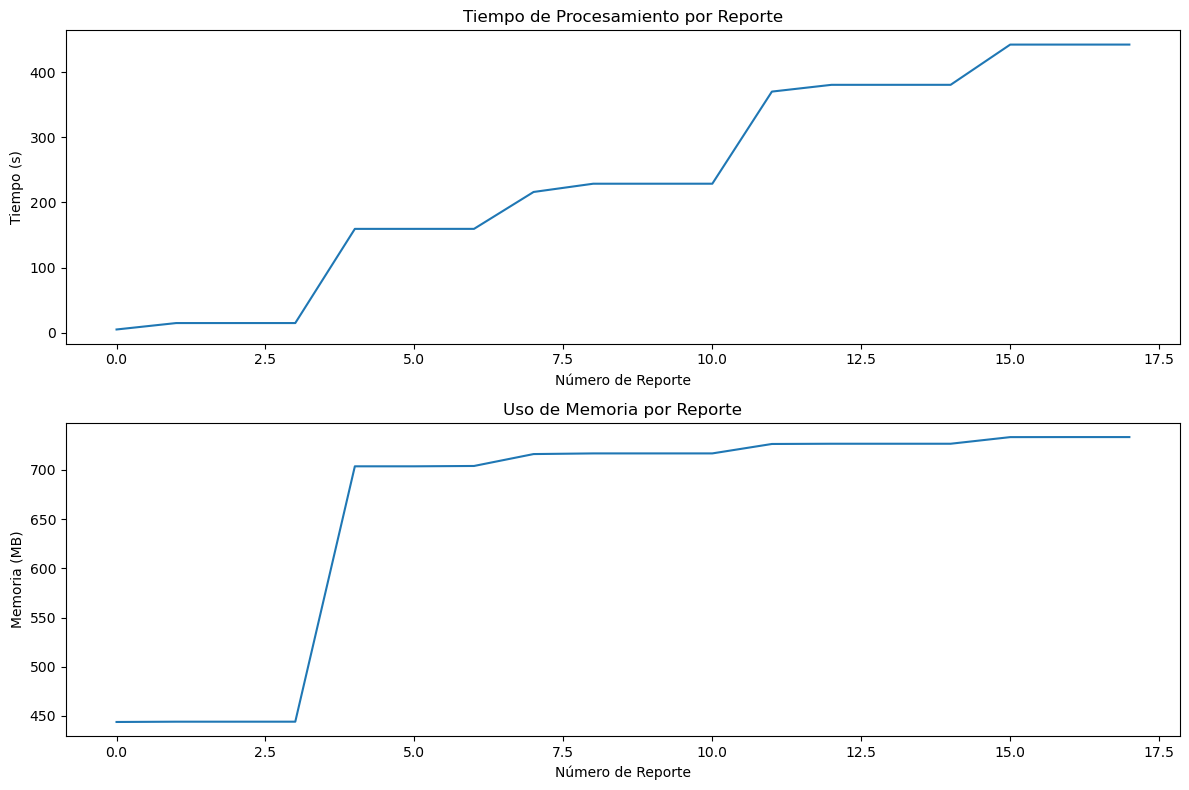

In [ ]:
# 1. Gráfico de rendimiento
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

times = performance_metrics['processing_time']
ax1.plot(times)
ax1.set_title('Tiempo de Procesamiento por Reporte')
ax1.set_xlabel('Número de Reporte')
ax1.set_ylabel('Tiempo (s)')

memory = performance_metrics['memory_usage']
ax2.plot(memory)
ax2.set_title('Uso de Memoria por Reporte')
ax2.set_xlabel('Número de Reporte')
ax2.set_ylabel('Memoria (MB)')

plt.tight_layout()
plt.show()

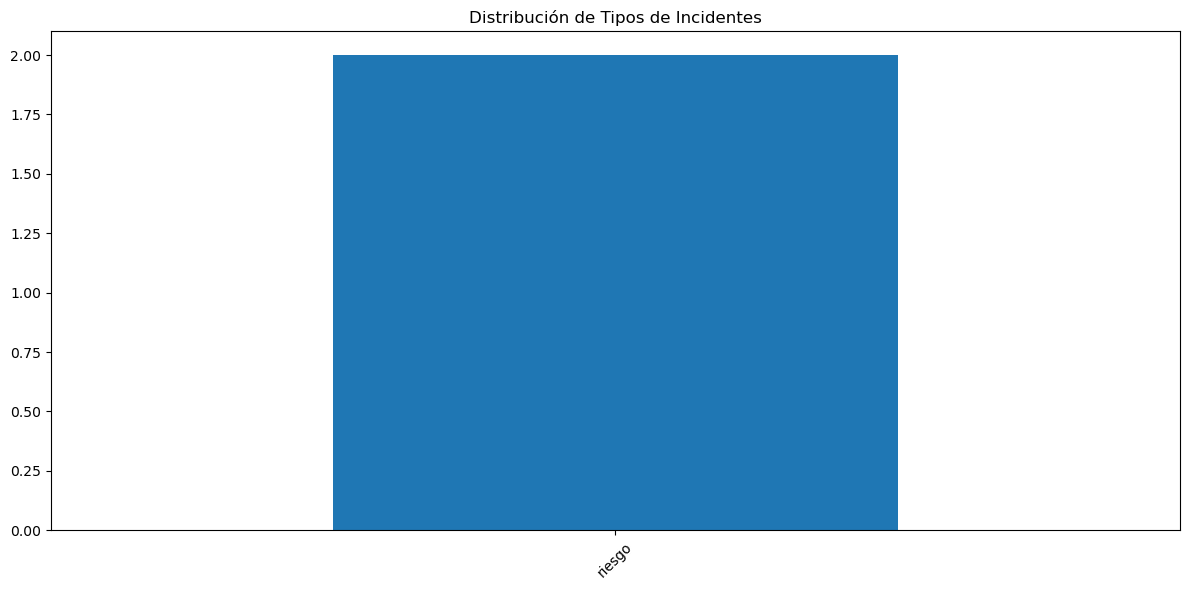

In [ ]:
# 2. Distribución de tipos de incidentes
incident_types = []
for result in analysis_results['individual_results']:
    for incident in result['incidents']:
        incident_types.append(incident['pattern'])

plt.figure(figsize=(12, 6))
pd.Series(incident_types).value_counts().plot(kind='bar')
plt.title('Distribución de Tipos de Incidentes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

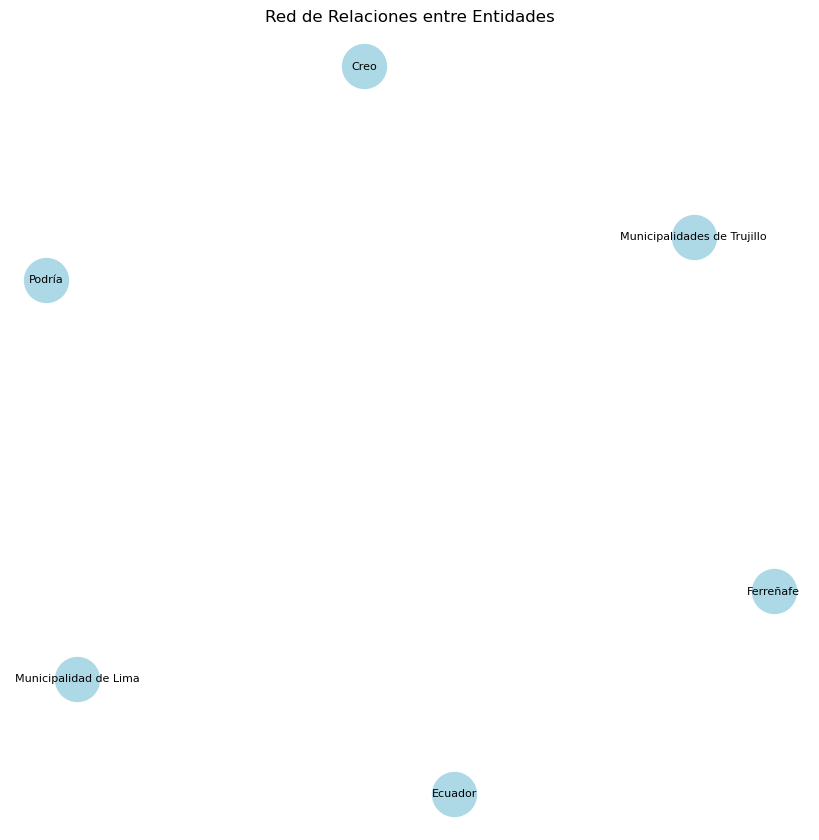

In [ ]:
# 3. Red de relaciones entre entidades
G = nx.Graph()
for result in analysis_results['individual_results']:
    entities = result['entities']
    for entity_type, entity_set in entities.items():
        for entity in entity_set:
            G.add_node(entity, type=entity_type)

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='lightblue',
        node_size=1000, font_size=8)
plt.title('Red de Relaciones entre Entidades')
plt.show()